In [5]:
import intprim
from intprim.probabilistic_movement_primitives import *
import matplotlib.pyplot as plt
from intprim.util.kinematics import BaseKinematicsClass
from cem import CEM
from utils import *
import time
from pytorch_fid.fid_score import calculate_frechet_distance
from ppo_via import Actor
import argparse
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import os
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib.patches import Rectangle

# state 是障碍物位置， 轨迹的起点终点固定

def get_args():
    parser = argparse.ArgumentParser(description="hyper parameters")
    parser.add_argument('--algo_name', default='PPO', type=str, help="name of algorithm")
    parser.add_argument('--train_eps', default=500, type=int, help="episodes of training")
    parser.add_argument('--test_eps', default=20, type=int, help="episodes of testing")
    parser.add_argument('--gamma', default=0.99, type=float, help="discounted factor")
    parser.add_argument('--mini_batch_size', default=5, type=int, help='mini batch size')
    parser.add_argument('--n_epochs', default=4, type=int, help='update number')
    parser.add_argument('--actor_lr', default=0.0003, type=float, help="learning rate of actor net")
    parser.add_argument('--critic_lr', default=0.0003, type=float, help="learning rate of critic net")
    parser.add_argument('--gae_lambda', default=0.95, type=float, help='GAE lambda')
    parser.add_argument('--policy_clip', default=0.3, type=float, help='policy clip')
    parser.add_argument('-batch_size', default=20, type=int, help='batch size')
    parser.add_argument('--hidden_dim', default=8, type=int, help='hidden dim')
    parser.add_argument('--device', default='cpu', type=str, help="cpu or cuda")
#     args = parser.parse_args()
    args = parser.parse_args(args=[])
    return args

cfg = get_args()

n_states=2
n_actions=2

actor =Actor(n_states, n_actions, cfg)
actor.load_checkpoint()

dataset= np.load('/home/zhiyuan/notebook_script/0930/l_shape.npy')
num_joints =2
basis_model = intprim.basis.GaussianModel(8, 0.1, ["x","y"])
promp = ProMP(basis_model)
Q = dataset.transpose(0,2,1)

for i in range(len(Q)):
	promp.add_demonstration(Q[i])
n_samples = 30
domain = np.linspace(0,1,100)

mean_margs =  np.zeros([2,100])
sigma_s = np.zeros([2,2,100])
# stdqs =  np.zeros([2,100])
for i in range(len(domain)):
    mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i])
    sigma_s[:,:,i] = Sigma_marg_q
    mean_margs[:,i] = mu_marg_q

# prepared for fid score
mu_1= mean_margs.T.reshape(-1)
sigma_1 = np.zeros([200,200])
for i in range(100):
    sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]


In [6]:
def get_via(limit):
    dist=actor(limit)
    via= dist.sample()
    
    return via.numpy() 
def plot_traj(limit):
    old_promp=promp

    via_point= get_via(limit)

    via_point = via_point.reshape([-1,2])
    t_cond = np.zeros(2+via_point.shape[0])
    t_cond[0]=0
    t_cond[-1] = 1
    for i in range(via_point.shape[0]):
        t_cond[i+1]=0.5

    q_cond =np.zeros([2+via_point.shape[0],2])
    q_cond[0]= mean_margs[:,0]
    q_cond[-1]= mean_margs[:,-1]
    for i in range(via_point.shape[0]):
        q_cond[i+1]=via_point[i,:2]
    print(via_point)
    mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

    for i in range(t_cond.shape[0]):
        mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)
    cond_traj = np.zeros([2,100])
    sigma_con_array =np.zeros([2,2,100]) 
    upper_bound_con =  np.zeros([2,100])
    lower_bound_con =  np.zeros([2,100])

    for i in range(len(domain)):
        mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
        sigma_con_array[:,:,i] = Sigma_marg_q_con
        cond_traj[:,i] = mu_marg_q_con
        std_q_con = np.diagonal(Sigma_marg_q_con)** 0.5
        upper_bound_con[:,i] = mu_marg_q_con + std_q_con
        lower_bound_con[:,i] = mu_marg_q_con - std_q_con

  
    
    # %matplotlib
    fig, ax = plt.subplots()
    ax.plot(cond_traj[0,:], cond_traj[1,:], 'r', alpha=0.3)
    ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)
    for i in range(t_cond.shape[0]):
        ax.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)

    #add rectangle to plor
    ax.add_patch(Rectangle((limit[0],limit[1]), 1, 1,

                 angle=0,
                 edgecolor = 'none',
                 facecolor = 'blue',
                 fill=True,
                 lw=1))


    plt.show()

tensor([[3.9483, 4.3200],
        [3.8764, 4.9842],
        [3.6520, 6.2783],
        [4.1729, 7.4191],
        [4.2041, 5.7366],
        [5.3917, 6.3179],
        [2.8658, 7.4290],
        [4.9873, 3.0957],
        [4.9600, 6.3993],
        [3.2474, 5.4946]], dtype=torch.float64)
[[4.478135 4.902105]]


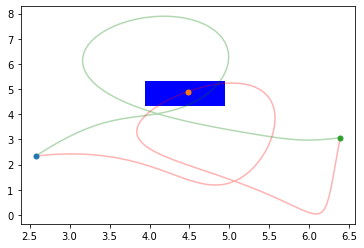

[[4.859838 5.438937]]


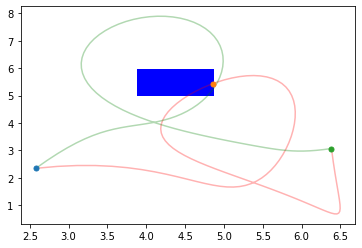

[[7.390642 7.121458]]


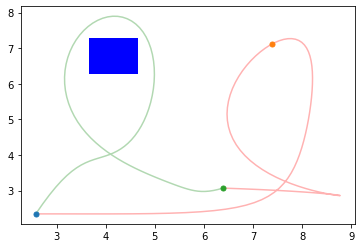

[[5.926858  4.9832907]]


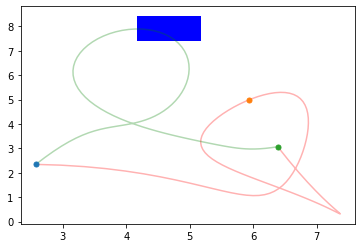

[[8.159866  6.0499296]]


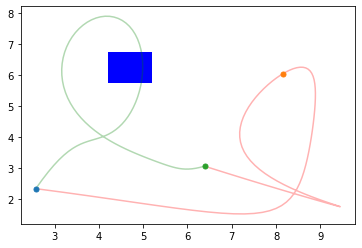

[[5.859209  5.5553718]]


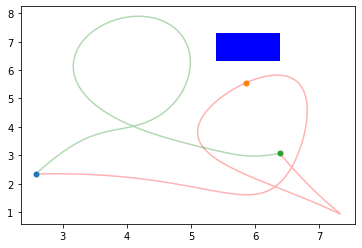

[[6.777626 5.040626]]


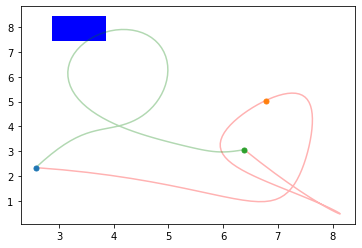

[[5.273944 6.113991]]


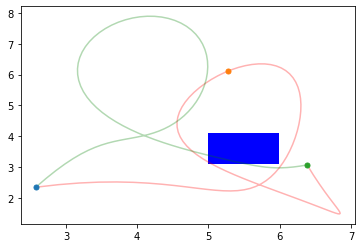

[[6.207307 5.359007]]


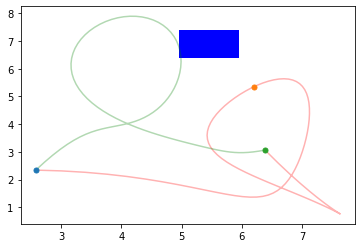

[[6.161353  5.3552833]]


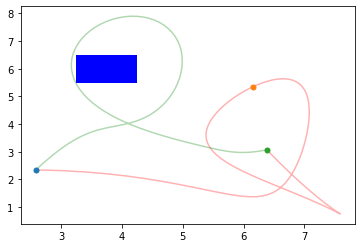

In [8]:
# # limit是tensor
start=mean_margs[:,0]
end=mean_margs[:,-1]
def env_reset():
    states = np.zeros(2)
    states[0]=np.random.uniform(2,6.5)
    states[1]=np.random.uniform(2,7.5)
    limit = np.array([[states[0],states[0]+1],[states[1],states[1]+1]])  
    d1= rect_dist(start,limit)
    d2= rect_dist(end,limit)
    while d1*d2 ==0:
        states[0]=np.random.uniform(2,6.5)
        states[1]=np.random.uniform(2,7.5)
        limit = np.array([[states[0],states[0]+1],[states[1],states[1]+1]])  
        d1= rect_dist(start,limit)
        d2= rect_dist(end,limit)
    return states



def sample_obst(num_ob):
    states=np.zeros([num_ob,2])
    for i in range(num_ob):
        states[i]=env_reset()       
    states = torch.from_numpy(states)
    return states

limits= sample_obst(10)
print(limits)
for i in range(10):
    _limit = limits[i]
#     print(get_via(_limit))
    plot_traj(_limit)
    

In [4]:
# for parameters in actor.parameters():
#     print(parameters)
